# Implementation of a Hopfield Network in Python
Here I implement a Hopfield network, a type of content-addressable memory system that uses a Hebbian Learning Rule to "Recall" the pattern that has been trained on to recover the prompted image.

This type of network is an important part of understanding parts of [attention blocks](https://alifuaziz.github.io/tutorials/attention-blocks-and-hopfield-networks/) as they serve as ways of associating different parts of patterns to eachother. 



In [45]:
## Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
from IPython.display import Image
from PIL import Image as PILImage
from skimage.transform import resize

In [2]:
filepath = '/Users/student/PycharmProjects/Oxford_MSc/MSc-Comp-Neuro/1_single_neuron_model/icons/'
image_list = []
for file in os.listdir(filepath):
    if file.endswith('.png'):
        # Open the image as numpy array
        image_path = filepath + file
        image = PILImage.open(image_path)
        image = image.convert('L')
        image = np.array(image)
        image_list.append(image)
        # Specify the desired dimensions for the downscaled image
        new_height = 100
        new_width = 100

        # Downscale each image in the image_list
        downscaled_image_list = []
        for image in image_list:
            downscaled_image = resize(image, (new_height, new_width), anti_aliasing=True)
            downscaled_image_list.append(downscaled_image)

# Convert the downscaled image list to a numpy array
downscaled_pattern_array = np.array(downscaled_image_list)

# convert the list to a numpy array
downscaled_pattern_array.shape

/Users/student/anaconda3/envs/machinelearning/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(3, 100, 100)

## Definition of Hopfield Network

Start with a class which defines the learning rule and recall (`predict`) rule. 

In [3]:
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        # Square matrix of zeros (that represent the weights between the neurons)
        # Network is fully connected 
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns):
        # This is the Hebbian learning rule (weights are the outer product of the patterns)
        for pattern in patterns:
            pattern = np.reshape(pattern, (self.num_neurons, 1))
            self.weights += np.dot(pattern, pattern.T) # (\sum_{i=1}^{p} x_i x_i^T) / N
        # There are no self-connections between neurons
        np.fill_diagonal(self.weights, 0)

    def predict(self, pattern):
        # "Incomplete" pattern presented to the network
        pattern = np.reshape(pattern, (self.num_neurons, 1))
        output = np.dot(self.weights, pattern)
        # if output is greater than 0, set it to 1
        output[output >= 0] = 1
        # if output is less than 0, set it to -1
        output[output < 0] = -1
        return output.flatten()


Please note that in the learning happens in one shot (one presentation of the data). This makes the hopefield network a very efficient (on data) type of machine learning algorithm. 

## Add noise to the image that needs to removed to recover the orginal image
Preprocessing step: due the implementation details of the network, it will only  learn binary patterns. Therefore, the image to be trained on must also be binary.

In [24]:
def binarize_patterns(patterns, threshold=0.5):
    # Binarize the patterns (i.e., convert them to -1s and 1s)
    patterns[patterns < threshold] = -1
    patterns[patterns >= threshold] = 1
    return patterns


def add_noise(image, noise_level):
    # Generate random noise with the same shape as the image array
    noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    # Add the noise to the image array
    corrupted_image = image + noise
    return corrupted_image



Example Binary Image Generated Below

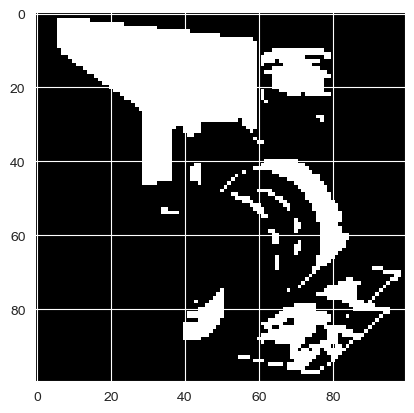

In [51]:
for image in downscaled_pattern_array:
    binary_image = binarize_patterns(image)
    plt.imshow(binary_image, cmap='gray')


corrupted_downscaled_pattern_array = []
for image in downscaled_pattern_array:
    corrupted_image = add_noise(image, 3)
    corrupted_downscaled_pattern_array.append(corrupted_image)

# make images 1d
pattern_list = []
for i in range(downscaled_pattern_array.shape[0]): 
    pattern_list.append(downscaled_pattern_array[i].flatten())

In [52]:
hf = HopfieldNetwork(10000)
# for pattern in pattern_list:
#     print(pattern.shape)
binary_pattern_list = []
for pattern in pattern_list:
    binary_pattern_list.append(binarize_patterns(pattern))
binary_pattern_list = np.array(binary_pattern_list)
hf.train(binary_pattern_list)

# Predict the output of the network for the corrupted images
predicted_downscaled_pattern_array = []
for image in corrupted_downscaled_pattern_array:
    predicted_image = hf.predict(image.flatten())
    predicted_downscaled_pattern_array.append(predicted_image)

# Convert the predicted image list to a numpy array
recovered_image_array = np.array(predicted_downscaled_pattern_array)
recovered_image_array = recovered_image_array.reshape((3, 100, 100))




# Plot Results
First row: Images Trained on 
Second row: Images that prompted the hopfield network
Third Row: The recovered images from the network from prediciton.

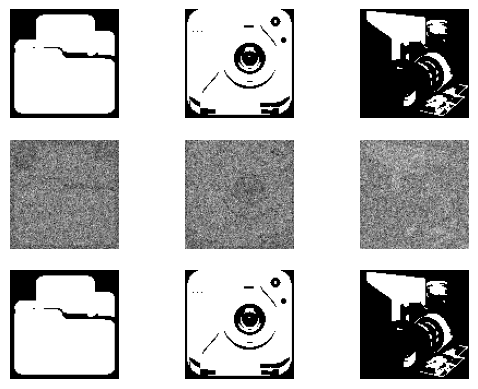

In [54]:
def plot_images(orginal_image_array,
                corrupted_image_array,
                recovered_image_array,
                ):
    # create subplots
    num_images = orginal_image_array.shape[0]
    fig, ax = plt.subplots(num_images, 3)


    # plot original images
    for image_idx, image in enumerate(orginal_image_array):
        ax[0, image_idx].imshow(image, cmap='gray')
        ax[0, image_idx].set_axis_off()  # remove axes

    # plot corrupted image
    for image_idx, image in enumerate(corrupted_image_array):
        ax[1, image_idx].imshow(image, cmap='gray')
        ax[1, image_idx].set_axis_off()  # remove axes

    # plot corrupted image array
    for image_idx, image in enumerate(recovered_image_array):
        ax[2, image_idx].imshow(image, cmap='gray')
        ax[2, image_idx].set_axis_off()  # remove axes


    plt.show()

plot_images(downscaled_pattern_array, 
            corrupted_downscaled_pattern_array, 
            recovered_image_array)
